In [1]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.layers.core import Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.metrics import categorical_crossentropy
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.models import load_model

import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import shutil
import os
import random

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import datasets

import time
from PIL import Image
from numba import jit
import pickle
from pathlib import Path
import skimage.measure
%matplotlib inline

from keras.optimizers import Adam

from keras.models import load_model
from sklearn import metrics

Using TensorFlow backend.


In [3]:
# check the nth ('n') of an integer 'num'
def check_nth_bit(num, n):
    return (num>>n)&1

# flip the bit of the integer 'int' at a position 'p'  (staring at 0)
def bitflip(int,p):
    mask = 1 << p
    return (int^ mask)

# count the numbers of 1 on a binarie representetion of an interger n
def CountBits(n):
    n = (n & 0x5555555555555555) + ((n & 0xAAAAAAAAAAAAAAAA) >> 1)
    n = (n & 0x3333333333333333) + ((n & 0xCCCCCCCCCCCCCCCC) >> 2)
    n = (n & 0x0F0F0F0F0F0F0F0F) + ((n & 0xF0F0F0F0F0F0F0F0) >> 4)
    n = (n & 0x00FF00FF00FF00FF) + ((n & 0xFF00FF00FF00FF00) >> 8)
    n = (n & 0x0000FFFF0000FFFF) + ((n & 0xFFFF0000FFFF0000) >> 16)
    n = (n & 0x00000000FFFFFFFF) + ((n & 0xFFFFFFFF00000000) >> 32) 
    return n

# defining n!
@jit
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)

# finding the states that have the maginetization "z"
@jit
def statep(y,z):
    a = 0
    for x in range(0,2**l):
        if (2* CountBits(x)-l) == z:
            y[a] = x
            a += 1
    return (y)

# numbers of states with magnatization x
def num_mag(x):
    y = p = int(factorial(l)//((factorial((x+l)/2))*(factorial(l -((x+l)/2)))))
    return y
            
# find the position in the list of states "s" that are iqual to "b"
@jit
def find_state(s,b):
    for z in range(0,p+1):
        if s[z] == b:
            return(z)

# power method
@jit
def power_iteration(A):
    # Choose a random vector
    y_0 = np.random.rand(A.shape[0])
    #erro precision
    e= 0.000000001
    #convergence constant
    er= 1.0
    it = 0
    while (er >= e):
        # calculate the matrix-by-vector product Ab
        z_1 = np.dot(A, y_0)
        # calculate the norm
        z_1_norm = np.linalg.norm(z_1)
        # renormalize the vector
        y_1 = z_1 / z_1_norm
        z_2 = np.dot(A, y_1)
        z_2_norm = np.linalg.norm(z_2)
        lamb_1 = np.dot(z_2,y_1)/np.dot(y_1,y_1)
        y_2 = z_2/z_2_norm
        z_3 = np.dot(A, y_2)
        z_3_norm = np.linalg.norm(z_3)
        lamb_2 = np.dot(z_3,y_2)/np.dot(y_2,y_2)
        er = abs(lamb_1 - lamb_2)/abs(lamb_2)
        y_0 = z_3/z_3_norm
        it += 1
        #if( it%10 == 0):print('# of interations:',it,';','Precision:', er)
    return (y_0, lamb_2)

@jit
def POWER_METHOD(A,dim):
    for x in range(0,dim):
        A[x,x] -= 2*l
        
    C = np.asarray(power_iteration(A))
    C[1] += 2*l
    return (C)

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.title('RMSE ='+ str(np.round(100000*score)/100000))
    plt.savefig('predct_l16.png')
    plt.show()
    
#plt.switch_backend('agg')

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'mean_squared_error' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'val_mean_squared_error' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig('loss_l16.png')
    plt.show()

In [12]:
path_folder = 'matrix_16/'

if not os.path.exists(path_folder):
    os.mkdir(path_folder)

h: -16.0
h: -14.4
h: -12.8
h: -11.200000000000001
h: -9.600000000000001
h: -8.000000000000002
h: -6.400000000000002
h: -4.8000000000000025
h: -3.2000000000000024
h: -1.6000000000000023
h: -2.220446049250313e-15
h: 1.5999999999999979
h: 3.199999999999998
h: 4.799999999999998
h: 6.399999999999999
h: 7.999999999999998
h: 9.599999999999998
h: 11.199999999999998
h: 12.799999999999997
h: 14.399999999999997
h: 15.999999999999996


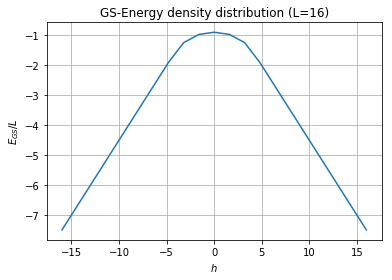

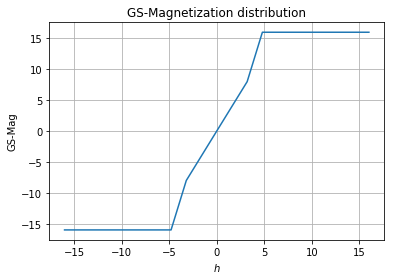

In [26]:
# number of spins
l = 16

#dimension constant
j = 1

#anisotropy constant
delt = -1

   
h = -16.
row = []
while h <= 16:
    
    Hxxz = np.zeros((2**l , 2**l ))

    # constructing the full xxz hamiltonian (2^L, 2^L) 
    for x in range(0,2**l):
        for y in range(0,l):
            k = (y+1)%l
            if check_nth_bit(x,y) == 0:
                Hxxz[x,x] += -j*h/2
            else:
                Hxxz[x,x] += j*h/2
            #if y != l-1:    
            if check_nth_bit(x,y) == check_nth_bit(x,k):
                Hxxz[x,x] += -(j*delt)/2
            else:
                Hxxz[x,x] += (j*delt)/2
                b = bitflip(x,y)
                c = bitflip(b,k)
                Hxxz[x,c] += -j

    
    
    mag_array = np.zeros(l+1)
    E_array = np.zeros(l+1)
    a = 0
    for mag in range(-l,l+1,2):
    
        p = num_mag(mag)
        state = np.array(range(p))
        s = statep(state,mag)
        
        Hxxz_p = np.zeros((p,p))
        for x in range(0,p):
            for y in range(0,l):
                if check_nth_bit(s[x],y) == 0:
                    Hxxz_p[x,x] += -(j*h)/2
                else:
                    Hxxz_p[x,x] += (j*h)/2
                k = (y+1)%l
                #if y != l-1:
                if check_nth_bit(s[x],y) == check_nth_bit(s[x],k):
                    Hxxz_p[x,x] += -(j*delt)/2
                else:
                    Hxxz_p[x,x] += (j*delt)/2
                    b = bitflip(s[x],y)
                    c = bitflip(b,k)
                    D = np.where(s == c)
                    Hxxz_p[x,D] = -j
                        #if mag == 0:
                            #print('[',x,D,']','k:',k,'s[x]:',s[x],'y:',y,'b:',b,'c:',c,'s[5]',s[5])
                    
        #print(Hxxz_p)
        mag_array[a] = mag
        A = POWER_METHOD(Hxxz_p,p)
        E_array[a] = A[1] 
        psi_s = -mag_array[np.where(E_array == np.min(E_array))]
        a += 1
    ex = '.npy'
    Hxxz_pool = skimage.measure.block_reduce(Hxxz,(256,256), np.average)
    np.save(os.path.abspath(path_folder + str(h)), Hxxz_pool)
    row.append([str(h) + ex, psi_s[0], np.min(E_array)/l, h])
            
        
    print('h:',h)
    #print('MAG_GS:', psi_s[0])
    #print('rhoE_array:', np.min(E_array)/l)
    h += 1.6
    
row = np.asarray(row)

a_h = np.array(row[:,3]).astype(np.float) #h
b_e = np.array(row[:,2]).astype(np.float) #E_GS/l
c_m = np.array(row[:,1]).astype(np.float) #mag_GS

plt.plot(a_h,b_e,'-')
plt.title('GS-Energy density distribution (L='+str(l)+')')
plt.xlabel(r'$h$')
plt
plt.ylabel(r'$E_{GS}/L$')
plt.grid()
plt.savefig('GS-Energy_l16.png')
plt.show()


plt.plot(a_h,c_m)
plt.title('GS-Magnetization distribution')
plt.xlabel(r'$h$')
plt.ylabel('GS-Mag')
plt.grid()
plt.savefig('GS-Mag_l16.png')
plt.show()


data_set = pd.DataFrame(row)
data_set.to_csv("pool_l16.csv")

In [27]:
x_test = row[:,0]
y_test = np.array(row[:,2]).astype(np.float)

In [28]:
test_data = []

load_test_data = []
for file in x_test:
        path = os.path.abspath(path_folder + file)
        H = np.load(path)
        load_test_data.append(H)
load_test_data = np.array(load_test_data)
test_data = load_test_data[:,:,:,np.newaxis]
test_data -= np.mean(test_data)
test_data /= np.std(test_data)

test_label = []
for file in y_test:
    test_label.append(file)
test_label = np.array(test_label)

In [29]:
print(test_data.shape,test_label.shape)


(21, 256, 256, 1) (21,)


21/21 [==============================] - 3s 129ms/step
Score (RMSE): 2.877833810337885


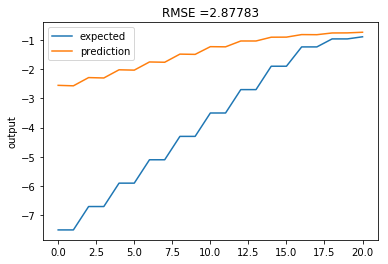

In [30]:
model = load_model('my_model.h5')

pred = model.predict(test_data, verbose=1)
score = np.sqrt(metrics.mean_squared_error(pred,test_label))
print("Score (RMSE): {}".format(score))

chart_regression(pred.flatten(),test_label)